# Imports

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import zscore
import scipy.stats as stats
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from mlxtend.evaluate import permutation_test
import statsmodels.api as sm

from category_encoders import TargetEncoder

from data_preparation import *
import warnings
warnings.filterwarnings("ignore")

In [158]:
train_prepared = pd.read_csv('./data/train_prepared.csv')
test_prepared = pd.read_csv('./data/test_prepared.csv')
df_app = pd.read_csv('./data/application_train_vf.csv')

train_prepared['SK_ID_CURR'] = df_app['SK_ID_CURR'].copy()
train_prepared['date_mensuelle'] = pd.to_datetime(train_prepared['date_mensuelle'])
test_prepared['date_mensuelle'] = pd.to_datetime(test_prepared['date_mensuelle'])

train_prepared.drop(columns = 'Unnamed: 0',inplace=True)
test_prepared.drop(columns = 'Unnamed: 0',inplace=True)

train_prepared['CODE_GENDER'] = train_prepared['CODE_GENDER'].apply(lambda x : 'F' if x == 'XNA' else x)
test_prepared['CODE_GENDER'] = test_prepared['CODE_GENDER'].apply(lambda x : 'F' if x == 'XNA' else x)
#dataprep = DataPreparation(train, test, 0.3)

df_met = pd.read_csv('./data/variables_sens_metier_discretisees.csv')
df_met['date_mensuelle'] = pd.to_datetime(df_met['date_mensuelle'])
#train_prepared = df_met.copy()
train_prepared = train_prepared.merge(df_met[['AMT_CREDIT_SUM_DEBT_disc','AMT_CREDIT_SUM_disc','NAME_EDUCATION_TYPE_discret','SK_ID_CURR']], on = 'SK_ID_CURR', how = 'left')

In [159]:
df_met = pd.read_csv('./data/bureau.csv')

In [160]:
df_met_group = df_met[['AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM','DAYS_CREDIT','SK_ID_CURR']].groupby('SK_ID_CURR').sum()
df_met_group.reset_index(inplace=True)
df_met_group['Nombre_credit_actif'] = df_met[df_met['CREDIT_ACTIVE'] == 'Active'].pivot_table(index='SK_ID_CURR', columns='CREDIT_ACTIVE', aggfunc='size', fill_value=0)

In [161]:
df_met_group['Nombre_credit_actif'] = df_met_group['Nombre_credit_actif'].apply(lambda x : 'Beaucoup de credit actif' if x > 3 else 'Pas de credit actif' if pd.isna(x) else 'Peu de credits actifs')

In [162]:
train_prepared = train_prepared.merge(df_met_group[['AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM','DAYS_CREDIT','Nombre_credit_actif','SK_ID_CURR']], on = 'SK_ID_CURR', how = 'left')

In [163]:
train_prepared['Nombre_credit_actif'] = train_prepared['Nombre_credit_actif'].apply(lambda x : 'Pas de credit actif' if pd.isna(x) else x)

In [164]:
for col in ['AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM','DAYS_CREDIT']:
    median = train_prepared[col].median()
    train_prepared[col] = train_prepared[col].fillna(0)

# temporaire

['AMT_PAYMENT', 'DAYS_CREDIT_ENDDATE', 'DAYS_FIRST_DRAWING','DAYS_BIRTH_disc_int___19282__13234_',
       'CNT_PAYMENT','DAYS_BIRTH_disc_int___25229__19283_','NAME_EDUCATION_TYPE_discret_lower','EXT_SOURCE_2_disc_int__0_0_0_09_', 'EXT_SOURCE_2_disc_int__0_45_0_85_','REGION_RATING_CLIENT_W_CITY','DAYS_CREDIT_ENDDATE']
       
Colonnes à traiter dans train_prepared : EXT_SOURCE_2_disc_int (2 modalités) ; DAYS_BIRTH ; NAME_EDUCATION_TYPE ; REGION_RATING_CLIENT_W_CITY ; NAME_CONTRACT_TYPE
Colonnes à traiter dans installment payment : AMT_PAYMENT
Colonnes à traiter dans previous_applicaiton : CNT_PAYMENT ; DAYS_FIRST_DRAWING
Colonnes à traiter dans bureau : DAYS_CREDIT_ENDDATE

['AMT_CREDIT_SUM_DEBT_disc', 'AMT_CREDIT_SUM_disc', 'EXT_SOURCE_2_disc_int', 'EXT_SOURCE_1_disc_int', 'EXT_SOURCE_3_disc_int','NAME_INCOME_TYPE_discret','REGION_POPULATION_RELATIVE_disc_int','DAYS_CREDIT_disc','Nombre_credit_actif']

In [201]:
df_app['AMT_PAYMENT']

KeyError: 'AMT_PAYMENT'

# discretisation

gen	nevals
0  	100   
1  	66    
2  	64    
3  	66    
4  	66    
5  	54    
6  	59    
7  	75    
8  	59    
9  	64    
10 	56    


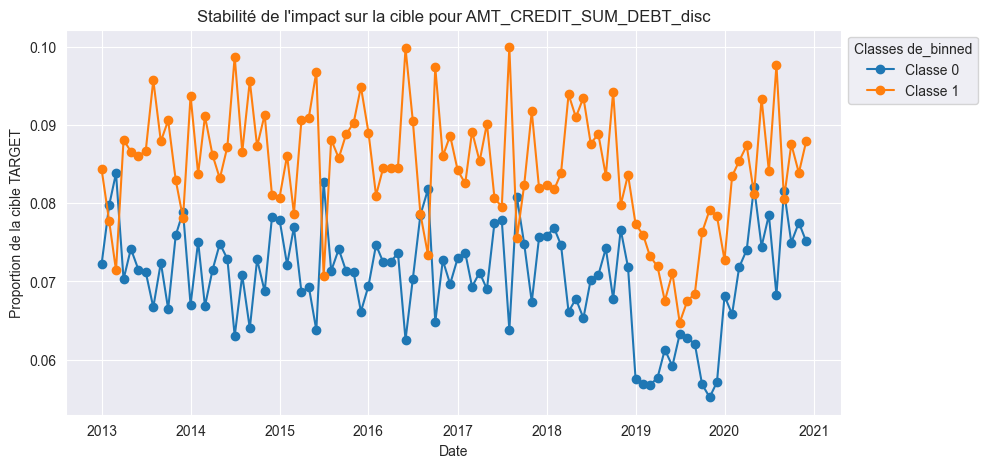

gen	nevals
0  	100   
1  	66    
2  	55    
3  	59    
4  	42    
5  	65    
6  	67    
7  	54    
8  	70    
9  	64    
10 	72    


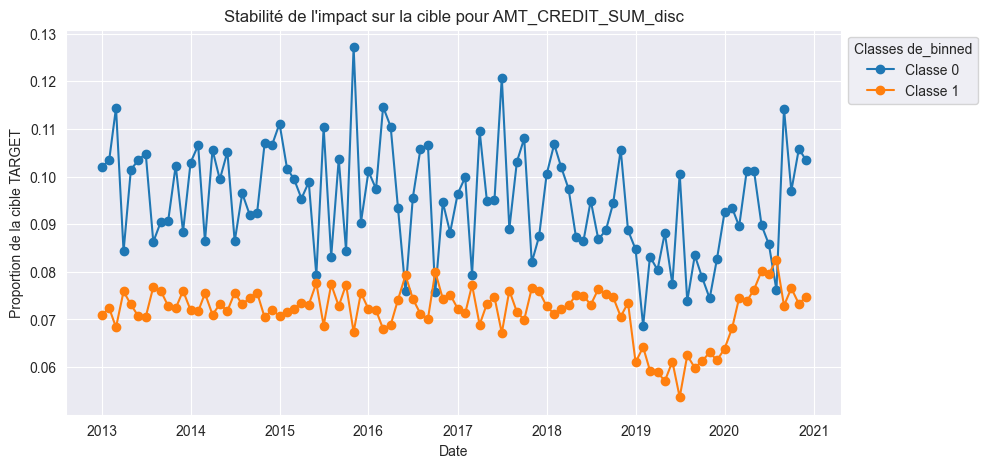

gen	nevals
0  	100   
1  	57    
2  	54    
3  	63    
4  	64    
5  	69    
6  	55    
7  	58    
8  	57    
9  	66    
10 	59    


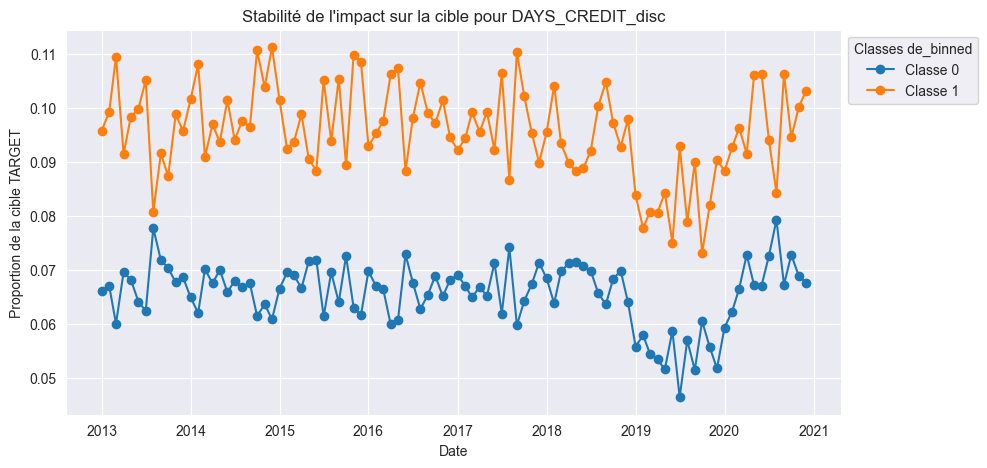

In [165]:
from deap import base, creator, tools, algorithms
from functools import  partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="deap.creator")


num = ['AMT_CREDIT_SUM_DEBT','AMT_CREDIT_SUM','DAYS_CREDIT']
var_to_categorize = [var for var in num if train_prepared[var].nunique() < 20]
num_final = [var for var in num if var not in var_to_categorize]

dict_variables = {}

for var in num_final:
    dict_variables[var] = 1


def calculate_stability(column):
    stability_df = train_prepared.groupby(['date_mensuelle', column])['TARGET'].mean().unstack()
    
    stability_df['stability'] = stability_df.std(axis=1) / stability_df.mean(axis=1)
    return stability_df

def plot_stability(variable):
    stability_df = calculate_stability(variable)  
    plt.figure(figsize=(10, 5))
    
    for class_label in stability_df.drop('stability', axis=1).columns:
        values = stability_df[class_label]
        plt.plot(stability_df.index, values, label=f'Classe {class_label}', marker='o')
    
    plt.title(f'Stabilité de l\'impact sur la cible pour {variable}')
    plt.xlabel('Date')
    plt.ylabel('Proportion de la cible TARGET')
    plt.legend(title=f'Classes de_binned', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    
    
def evalChi2(individual, variable):
    individual_sorted = sorted(individual)
    percentiles = [max(0, min(i * 100, 100)) for i in individual_sorted]
    thresholds = np.percentile(train_prepared[variable].dropna(), percentiles)
    
    thresholds = np.unique(thresholds)
    
    disc_var = np.digitize(train_prepared[variable], thresholds)
    train_prepared['disc_var'] = disc_var
    
    contingency_table = pd.crosstab(train_prepared['disc_var'],train_prepared['TARGET'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2,


def Run_Genetic_Discretisation(VARIABLE, NB_CLASSES_MAX):
    NB_GEN = 10
    POP_SIZE = 100  
    CXPB, MUTPB = 0.5, 0.2  


    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    
    def custom_crossover(ind1, ind2):
        if len(ind1) > 1 and len(ind2) > 1:
            return tools.cxTwoPoint(ind1, ind2)
        else:
            return ind1, ind2

    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=NB_CLASSES_MAX)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", partial(evalChi2, variable=VARIABLE))
    toolbox.register("mate", custom_crossover)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    population = toolbox.population(n=POP_SIZE)
    algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NB_GEN, verbose=True)
    
    best_ind = tools.selBest(population, 1)[0]
    return(best_ind)
for variable in dict_variables : 
    bins = Run_Genetic_Discretisation(variable, dict_variables[variable])
    bins_normalise = sorted([min(1, max(0, val)) for val in bins])
    
    seuils = np.percentile(train_prepared[variable].dropna(), [val * 100 for val in bins_normalise])
    seuils_uniques = np.unique(seuils)
    
    train_prepared[f'{variable}_disc'] = np.digitize(train_prepared[variable], seuils_uniques)
    
    stability_df = calculate_stability(f'{variable}_disc')  
    plt.figure(figsize=(10, 5))
    
    for class_label in stability_df.drop('stability', axis=1).columns:
        values = stability_df[class_label]
        plt.plot(stability_df.index, values, label=f'Classe {class_label}', marker='o')
    
    plt.title(f'Stabilité de l\'impact sur la cible pour {variable}_disc')
    plt.xlabel('Date')
    plt.ylabel('Proportion de la cible TARGET')
    plt.legend(title=f'Classes de_binned', loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [166]:
X = train_prepared.drop(columns=['date_mensuelle'])
y = train_prepared['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


# Logit statsmodels

Optimization terminated successfully.
         Current function value: 0.250099
         Iterations 7


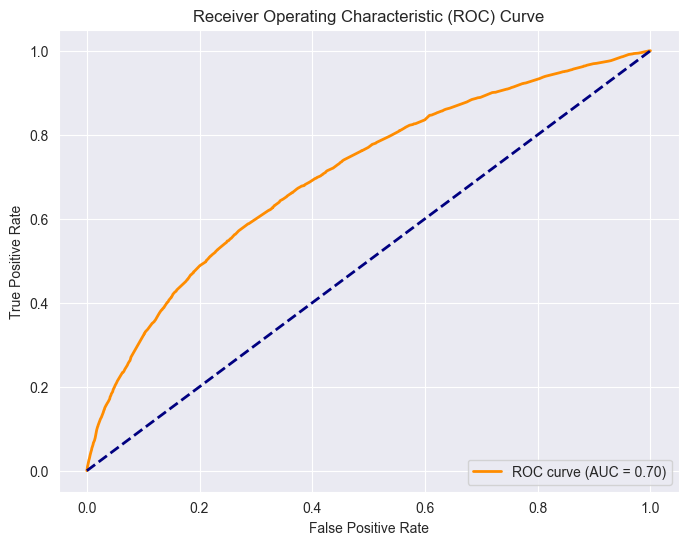

Gini : 0.4087395334633972 , AUC : 0.7043697667316986


In [167]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from statsmodels.discrete.discrete_model import Logit

features = ['AMT_CREDIT_SUM_DEBT_disc', 'AMT_CREDIT_SUM_disc', 'EXT_SOURCE_2_disc_int', 'EXT_SOURCE_1_disc_int', 'EXT_SOURCE_3_disc_int','NAME_INCOME_TYPE_discret','REGION_POPULATION_RELATIVE_disc_int','DAYS_CREDIT_disc','Nombre_credit_actif']

replacement_dict = {1: 'un', 0: 'zero', 2: 'deux', 3: 'trois'}

df_train = X_train.copy()
df_validation = X_test.copy()

for var in features:
   df_train[var] = df_train[var].replace(replacement_dict)
   df_validation[var] = df_validation[var].replace(replacement_dict)


df_train["TARGET"] = df_train["TARGET"].astype("int")


reference_categories = {var: df_train[var].mode()[0] for var in features}
formula_parts = []
for var in features:
    if var in reference_categories:
        ref_category = reference_categories[var]
        formula_parts.append(f'C({var}, Treatment(reference="{ref_category}"))')

formula = 'TARGET ~ ' + ' + '.join(formula_parts)

model = Logit.from_formula(formula=formula, data=df_train)
logit_model = model.fit()

# Prédiction
pred = logit_model.predict(df_validation)
fpr, tpr, thresholds = roc_curve(df_validation["TARGET"],pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
roc_auc = auc(fpr, tpr)
gini_coefficient = 2 * roc_auc - 1
print(f'Gini : {gini_coefficient} , AUC : {roc_auc}')

In [168]:
logit_model.summary2().tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-3.114644,0.021714,-143.438094,0.000000e+00,-3.157203,-3.072085
"C(AMT_CREDIT_SUM_DEBT_disc, Treatment(reference=""zero""))[T.un]",0.305542,0.019280,15.847979,1.451744e-56,0.267755,0.343329
"C(AMT_CREDIT_SUM_disc, Treatment(reference=""un""))[T.zero]",0.408459,0.024748,16.504899,3.382995e-61,0.359955,0.456964
"C(EXT_SOURCE_2_disc_int, Treatment(reference=""[0.45;0.85]""))[T.[0.09;0.45]]",0.695520,0.016621,41.847055,0.000000e+00,0.662944,0.728095
"C(EXT_SOURCE_2_disc_int, Treatment(reference=""[0.45;0.85]""))[T.[0.0;0.09]]",1.405237,0.029328,47.914816,0.000000e+00,1.347755,1.462718
"C(EXT_SOURCE_1_disc_int, Treatment(reference=""[0.0;0.07]""))[T.[0.07;0.41]]",0.128255,0.019844,6.463031,1.026265e-10,0.089361,0.167150
"C(EXT_SOURCE_1_disc_int, Treatment(reference=""[0.0;0.07]""))[T.[0.41;0.96]]",-0.549975,0.021340,-25.772412,1.807970e-146,-0.591800,-0.508150
"C(EXT_SOURCE_3_disc_int, Treatment(reference=""[0.31;0.9]""))[T.[0.0;0.31]]",0.993664,0.018645,53.293975,0.000000e+00,0.957121,1.030208
"C(NAME_INCOME_TYPE_discret, Treatment(reference=""high_income""))[T.low_income]",1.570736,0.431053,3.643952,2.684835e-04,0.725888,2.415584
"C(NAME_INCOME_TYPE_discret, Treatment(reference=""high_income""))[T.other]",-0.441480,0.020655,-21.373875,2.338911e-101,-0.481963,-0.400997


# Xgboost

In [183]:
train_prepared.columns

Index(['TARGET', 'date_mensuelle', 'DAYS_BIRTH_disc_int',
       'EXT_SOURCE_2_disc_int', 'EXT_SOURCE_1_disc_int',
       'AMT_GOODS_PRICE_disc_int', 'DAYS_REGISTRATION_disc_int',
       'DAYS_LAST_PHONE_CHANGE_disc_int', 'EXT_SOURCE_3_disc_int',
       'AMT_CREDIT_disc_int', 'AMT_ANNUITY_disc_int',
       'REGION_POPULATION_RELATIVE_disc_int', 'DAYS_EMPLOYED_disc_int',
       'DAYS_ID_PUBLISH_disc_int', 'AMT_REQ_CREDIT_BUREAU_MON_disc_int',
       'OWN_CAR_AGE_disc_int', 'YEARS_BEGINEXPLUATATION_MEDI_disc_int',
       'YEARS_BEGINEXPLUATATION_MODE_disc_int',
       'YEARS_BEGINEXPLUATATION_AVG_disc_int', 'NAME_INCOME_TYPE_discret',
       'NAME_EDUCATION_TYPE_discret', 'NAME_FAMILY_STATUS_discret',
       'OCCUPATION_TYPE_discret', 'FLAG_EMP_PHONE', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_O

In [189]:
train_prepared2 = train_prepared.drop(columns = ['EXT_SOURCE_2_disc_int','EXT_SOURCE_1_disc_int']).copy()

for col in train_prepared2.select_dtypes(include='object').columns:
    one_hot_encoded = pd.get_dummies(train_prepared2[col], prefix=col, drop_first=True)
    train_prepared2 = train_prepared2.drop(col, axis=1)
    train_prepared2 = train_prepared2.join(one_hot_encoded)

# Encoding boolean values as 1 for True and 0 for False
for col in train_prepared2.select_dtypes(include=bool).columns:
    train_prepared2[col] = train_prepared2[col].astype(int)

In [190]:
X = train_prepared2.drop(columns = ['TARGET','date_mensuelle'])#[['AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM', 'EXT_SOURCE_2_disc_int_[0.0;0.09]', 'EXT_SOURCE_2_disc_int_[0.45;0.85]',
#       'EXT_SOURCE_1_disc_int_[0.0;0.07]', 'EXT_SOURCE_1_disc_int_[0.41;0.96]', 'EXT_SOURCE_3_disc_int_[0.31;0.9]','NAME_INCOME_TYPE_discret_low_income', 'NAME_INCOME_TYPE_discret_other']]
y = train_prepared2['TARGET']

X_train2, X_test2, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


In [191]:
new_columns = []
for col in X_train2.columns:
    new_col = col.replace('[', '_').replace(']', '_').replace(';', '_').replace('-', '_').replace('.', '_')
    new_columns.append(new_col)

X_train2.columns = new_columns


new_columns = []
for col in X_test2.columns:
    new_col = col.replace('[', '_').replace(']', '_').replace(';', '_').replace('-', '_').replace('.', '_')
    new_columns.append(new_col)

X_test2.columns = new_columns

In [193]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import optuna

variables = X_train2.columns

var_supp = []

prev_auc = 0


while len(variables)>8:
    
    study = optuna.create_study(direction='maximize')
    
    def objective(trial):
        C = trial.suggest_loguniform('C', 1e-3, 5)
        logistic_model = LogisticRegression(C=C)
        logistic_model.fit(X_train2[variables], y_train)
        y_prob = logistic_model.predict_proba(X_test2[variables])[:, 1]
        auc = roc_auc_score(y_test, y_prob)
        return auc
    
    study.optimize(objective, n_trials=10)
    
    logistic_model = LogisticRegression(C=study.best_params['C'])
    logistic_model.fit(X_train2[variables], y_train)
    
    y_prob = logistic_model.predict_proba(X_test2[variables])[:, 1]
    
    current_auc = roc_auc_score(y_test, y_prob)
    
    if current_auc > prev_auc:
        var_finales = variables.copy()
        f1_final = current_auc
        param_final = study.best_params['C']
        
    min_coef_idx = np.argmin(np.abs(logistic_model.coef_))
    
    variables = list(variables)
    variables.pop(min_coef_idx)

    var_supp.append(min_coef_idx)
    
    prev_auc = current_auc

# Afficher les résultats
print("Meilleur alpha trouvé :", param_final)
print("Meilleue AUC trouvé :", f1_final)
print("Variables sélectionnées :", var_finales)


[I 2024-02-24 17:35:07,089] A new study created in memory with name: no-name-6ab8d1b0-07a6-4b7c-b854-8da1f76cc444
[I 2024-02-24 17:35:10,906] Trial 0 finished with value: 0.5427621364649083 and parameters: {'C': 0.8944083838349577}. Best is trial 0 with value: 0.5427621364649083.
[I 2024-02-24 17:35:13,502] Trial 1 finished with value: 0.5427614245949379 and parameters: {'C': 0.08350205052072093}. Best is trial 0 with value: 0.5427621364649083.
[I 2024-02-24 17:35:15,898] Trial 2 finished with value: 0.5427620197031672 and parameters: {'C': 0.3170733026487332}. Best is trial 0 with value: 0.5427621364649083.
[I 2024-02-24 17:35:18,424] Trial 3 finished with value: 0.5426496836086384 and parameters: {'C': 0.15338574471360772}. Best is trial 0 with value: 0.5427621364649083.
[I 2024-02-24 17:35:20,573] Trial 4 finished with value: 0.5427595375745404 and parameters: {'C': 0.005713896386845514}. Best is trial 0 with value: 0.5427621364649083.
[I 2024-02-24 17:35:22,712] Trial 5 finished wi

Meilleur alpha trouvé : 0.004499950624425172
Meilleue AUC trouvé : 0.7016132611959207
Variables sélectionnées : ['REGION_RATING_CLIENT_W_CITY', 'AMT_CREDIT_SUM_DEBT_disc', 'AMT_CREDIT_SUM_disc', 'DAYS_CREDIT_disc', 'DAYS_BIRTH_disc_int___25229__19283_', 'AMT_GOODS_PRICE_disc_int__679500_0_4050000_0_', 'DAYS_LAST_PHONE_CHANGE_disc_int___4292_0__1088_0_', 'EXT_SOURCE_3_disc_int__0_31_0_9_', 'DAYS_EMPLOYED_disc_int___2443_365243_', 'YEARS_BEGINEXPLUATATION_MODE_disc_int__0_97_1_0_', 'NAME_INCOME_TYPE_discret_other', 'NAME_EDUCATION_TYPE_discret_lower', 'NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_M', 'FLAG_OWN_CAR_Y']


In [84]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Assume X_train, X_test, y_train, y_test are defined

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',  # Utilisation de l'aire sous la courbe ROC comme métrique d'évaluation
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'eta': trial.suggest_loguniform('eta', 0.05, 0.4),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 90, 150),
        'alpha': trial.suggest_loguniform('alpha', 0.05, 1.0)
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train2, y_train)
    y_pred_proba = model.predict_proba(X_test2)[:, 1]  # Probabilité de la classe positive
    auc_score = roc_auc_score(y_test, y_pred_proba)  # Calcul de l'aire sous la courbe ROC
    return auc_score

# Create an Optuna study object and perform the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Display the optimization results
print(f"Best parameters: {study.best_params}")
print(f"Best positive f1 score: {study.best_value}")


[I 2024-02-24 12:42:24,200] A new study created in memory with name: no-name-bb8d3cc2-8c3c-4233-af20-7d2080f51e26
[I 2024-02-24 12:42:40,173] Trial 0 finished with value: 0.6839060604413573 and parameters: {'max_depth': 20, 'eta': 0.22444920740130536, 'gamma': 1.9566260215910867e-08, 'colsample_bytree': 0.8667298124673004, 'subsample': 0.8297425670489839, 'n_estimators': 116, 'alpha': 0.23287153705280225}. Best is trial 0 with value: 0.6839060604413573.
[I 2024-02-24 12:42:47,080] Trial 1 finished with value: 0.7112099864422909 and parameters: {'max_depth': 7, 'eta': 0.16285517685850123, 'gamma': 1.2978749229545545e-07, 'colsample_bytree': 0.9425155018537688, 'subsample': 0.8653196400144791, 'n_estimators': 131, 'alpha': 0.9942187151651234}. Best is trial 1 with value: 0.7112099864422909.
[I 2024-02-24 12:43:05,907] Trial 2 finished with value: 0.682606763898933 and parameters: {'max_depth': 19, 'eta': 0.15756796523403852, 'gamma': 1.516447901941977e-05, 'colsample_bytree': 0.985532207

KeyboardInterrupt: 

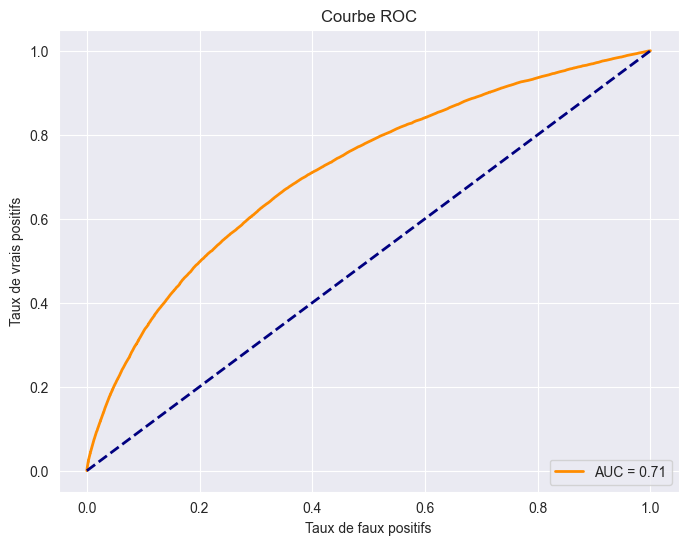

In [115]:
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



params = {'max_depth': 7, 'eta': 0.3619081800824767, 'gamma': 6.977954148681437e-06, 'colsample_bytree': 0.8736582384510414, 'subsample': 0.6583654387290991, 'n_estimators': 143, 'alpha': 0.19270106587750738}

params = study.best_params

# Créer le modèle avec les hyperparamètres spécifiés
model = xgb.XGBClassifier(**params)

# Entraîner le modèle
model.fit(X_train2, y_train)

# Faire des prédictions sur l'ensemble de test
y_prob = model.predict_proba(X_test2)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Afficher la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

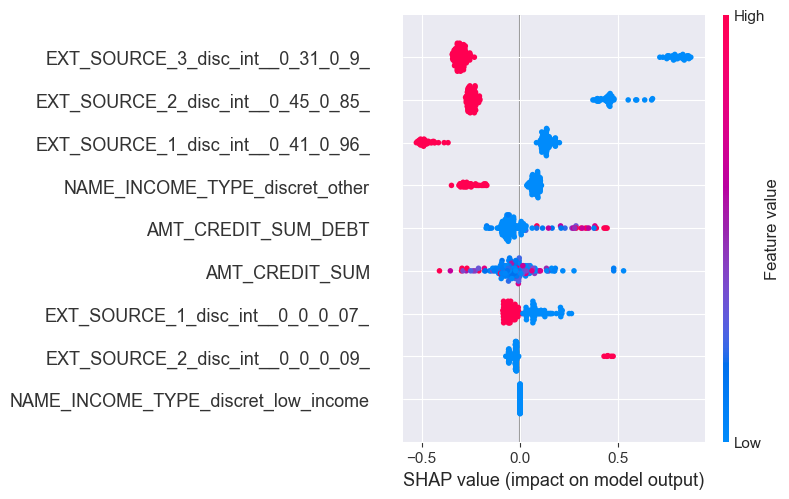

In [116]:
import shap


explainer = shap.TreeExplainer(model)

# Calculer les Shapley values pour un échantillon de données (par exemple, les 100 premières observations)
shap_values = explainer.shap_values(X_train2.iloc[:150, :])

# Afficher les Shapley values pour la première observation
shap.summary_plot(shap_values, X_train2.iloc[:150, :])

# Si vous voulez expliquer une prédiction spécifique pour une observation donnée, utilisez la fonction shap_values
# par exemple, pour expliquer la prédiction pour la première observation :
shap_values_single = explainer.shap_values(X_train2.iloc[[0]])
shap.force_plot(explainer.expected_value, shap_values_single, X_train2.iloc[[0]])

In [33]:
import numpy as np
shap_values_avg = np.abs(shap_values).mean(axis=0)
top_variables_indices = np.argsort(shap_values_avg)[::-1]


n_top_variables = 15
top_variables = X_train2.columns[top_variables_indices[:n_top_variables]]

top_variables

Index(['AMT_CREDIT_SUM_DEBT_disc', 'AMT_CREDIT_SUM_disc',
       'EXT_SOURCE_2_disc_int__0_45_0_85_', 'EXT_SOURCE_3_disc_int__0_31_0_9_',
       'EXT_SOURCE_1_disc_int__0_41_0_96_', 'NAME_INCOME_TYPE_discret_other',
       'EXT_SOURCE_1_disc_int__0_0_0_07_', 'EXT_SOURCE_2_disc_int__0_0_0_09_',
       'NAME_INCOME_TYPE_discret_low_income'],
      dtype='object')